<a href="https://colab.research.google.com/github/flaviowu/btc-c14-g4/blob/main/notebooks/Analise_Preliminar_An%C3%A1lise_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Exploratória 1

### Import e leitura dos dados

In [1]:
import pandas as pd 
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
test = pd.read_csv('/content/drive/MyDrive/Dados/test.tsv', sep = '\t')
train = pd.read_csv('/content/drive/MyDrive/Dados/train.tsv', sep = '\t')
test_stg = pd.read_csv('/content/drive/MyDrive/Dados/test_stg2.tsv', sep = '\t')

sample_submission_stg = pd.read_csv('/content/drive/MyDrive/Dados/sample_submission.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Dados/sample_submission_stg2.csv')

### Código Prof. Thiago [ Colunas Auxiliares ]

In [4]:
from numpy import random
def data(n, seed):

    datas = []
    
    random.seed(seed)
    for i in range(n):
        dia_maximo = 30
        dia_minimo = 1
        mes_maximo = 12
        mes_minimo = 1
        
        dia = int(random.random() * (dia_maximo - dia_minimo) + dia_minimo)
        mes = int(random.random() * (mes_maximo - mes_minimo) + mes_minimo)
        
        datas.append(str(dia)+'-'+str(mes)+'-2018')
        
    return datas

def estoque(n, seed):

    np.random.seed(seed)
    mu, sigma = 1, 20
    s = np.random.normal(mu, sigma, n)
    s[s < 0] = s[s < 0] * -0.5
    s = s.astype(int)
    s[s < 1] = 1
    
    return s

train['date']  = data(n = train.shape[0], seed = 10)
train['stock'] = estoque(n = train.shape[0], seed = 10)

test['date']  = data(n = test.shape[0], seed = 15)
test['stock'] = estoque(n = test.shape[0], seed = 15)

### Reconhecimento dos Dados

In [5]:
train.columns = ['id', 'nome_produto', 'id_condicao_item', 'nome_categoria', 'nome_marca', 'preço',
       'envio', 'descricao_item', 'data', 'stock']

In [6]:
train.set_index('id', inplace=True)

In [7]:
train.head(3)

,nome_produto,id_condicao_item,nome_categoria,nome_marca,preço,envio,descricao_item,data,stock
id,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,23-1-2018,27
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,19-9-2018,15
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,15-3-2018,14


In [8]:
train['data'].loc[(train.data.str.startswith('29-2')) 
                | (train.data.str.startswith('30-2'))] = np.nan

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
train.describe(include='O')

,nome_produto,nome_categoria,nome_marca,descricao_item,data
count,1482535,1476208,849853,1482531,1477853
unique,1225273,1287,4809,1281426,318
top,Bundle,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,No description yet,11-2-2018
freq,2232,60177,54088,82489,4826


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482535 entries, 0 to 1482534
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   nome_produto      1482535 non-null  object 
 1   id_condicao_item  1482535 non-null  int64  
 2   nome_categoria    1476208 non-null  object 
 3   nome_marca        849853 non-null   object 
 4   preço             1482535 non-null  float64
 5   envio             1482535 non-null  int64  
 6   descricao_item    1482531 non-null  object 
 7   data              1477853 non-null  object 
 8   stock             1482535 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 113.1+ MB


### Visualização preliminar

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

In [12]:
df = train

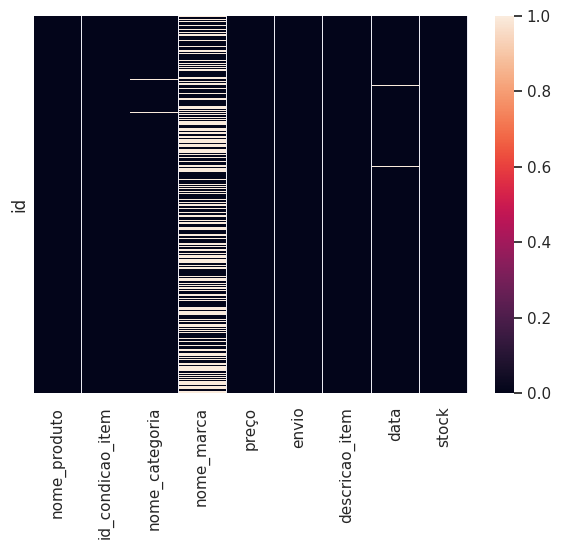

In [13]:
#valores nulos

plt.figure(figsize=(7, 5), dpi=100)
sns.heatmap(df.isnull(), yticklabels=False)
plt.show()

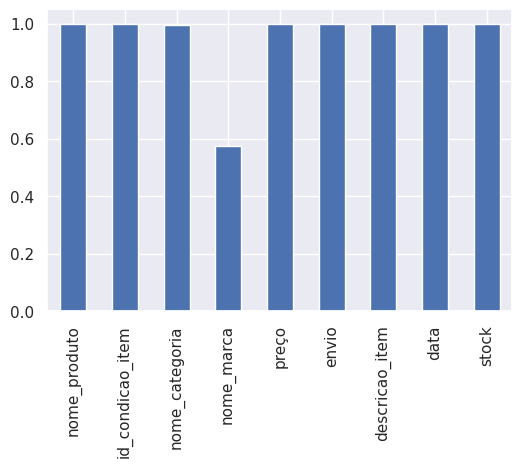

In [14]:
#Coluna com valores nulos

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
(1 - df.isnull().mean()).abs().plot.bar(ax=ax)
plt.show()

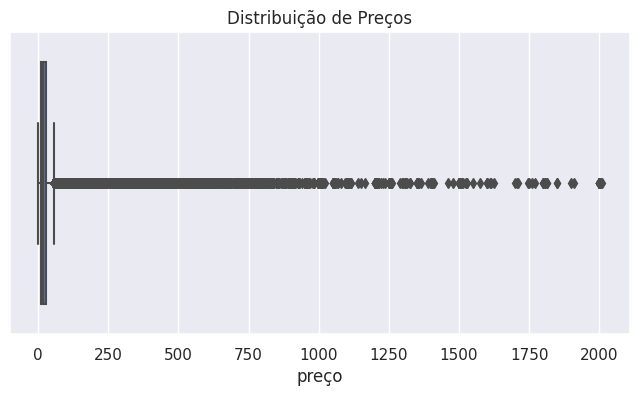

In [15]:
plt.figure(figsize=(8, 4), dpi=100)
sns.boxplot(x='preço', data=df)
plt.title('Distribuição de Preços')
plt.show()

Pensando na criação do modelo, é preciso usar engenharia de recursos tanto para identificar as marcas ausentes, como também, para aumentar o nível de entendimento do algoritimo sobre a classificação. As colunas de Condição do item e envio tem respectivamente, 5 e 2 atributos que ajudam a classificar, mas as demais colunas possuem atributos diversos. Para fazer a engenharia de recursos, o NLTK pode auxiliar na classificação da descrição, nome de categoria e marca.

# Análise Exploratória 2

### Criando Sub-categorias

In [16]:
train = train.dropna(subset=['nome_categoria'])

In [17]:
train['nome_categoria'] = train['nome_categoria'].apply(lambda x: x.split('/'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
categoria = train['nome_categoria'].apply(lambda x: x[0])
sub_categoria = train['nome_categoria'].apply(lambda x: x[1])
sub_categoria_item = train['nome_categoria'].apply(lambda x: x[2])

In [19]:
train.drop('nome_categoria', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
train['categoria'] = categoria
train['sub_categoria'] = sub_categoria
train['sub_categoria_item'] = sub_categoria_item

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [21]:
train.shape

(1476208, 11)

In [22]:
train[['categoria',	'sub_categoria',	'sub_categoria_item']].describe(include='O')

,categoria,sub_categoria,sub_categoria_item
count,1476208,1476208,1476208
unique,10,113,870
top,Women,Athletic Apparel,"Pants, Tights, Leggings"
freq,664385,134383,60177


### Investigando Relações

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


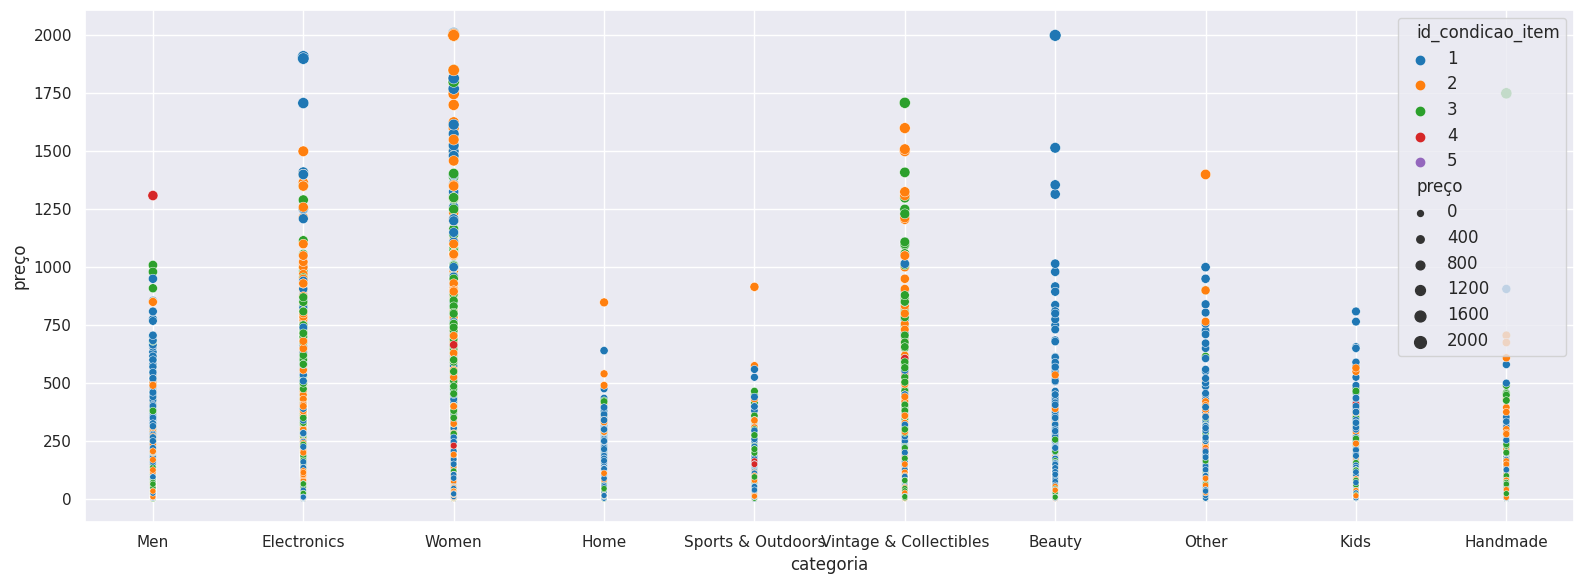

In [23]:
plt.figure(figsize=(16,6), dpi=100)
sns.scatterplot(x='categoria', y='preço', hue='id_condicao_item', size='preço', palette='tab10' , data= train)
plt.tight_layout()
plt.show()

In [24]:
analise_do_item = train.loc[train['sub_categoria_item']== 'Shoes']

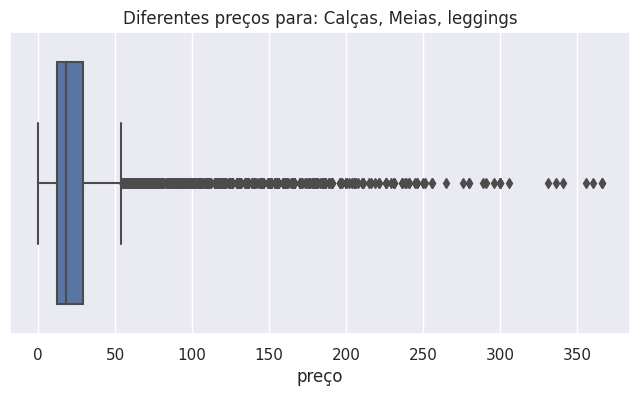

In [25]:
plt.figure(figsize=(8, 4), dpi=100)
sns.boxplot(x='preço', data=analise_do_item)
plt.title('Diferentes preços para: Calças, Meias, leggings')
plt.show()

In [26]:
train['sub_categoria_item'].value_counts()

Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
St Patricks                    1
Garbage Disposals              1
Decorating                     1
Pet Food                       1
Ephemera                       1
Name: sub_categoria_item, Length: 870, dtype: int64

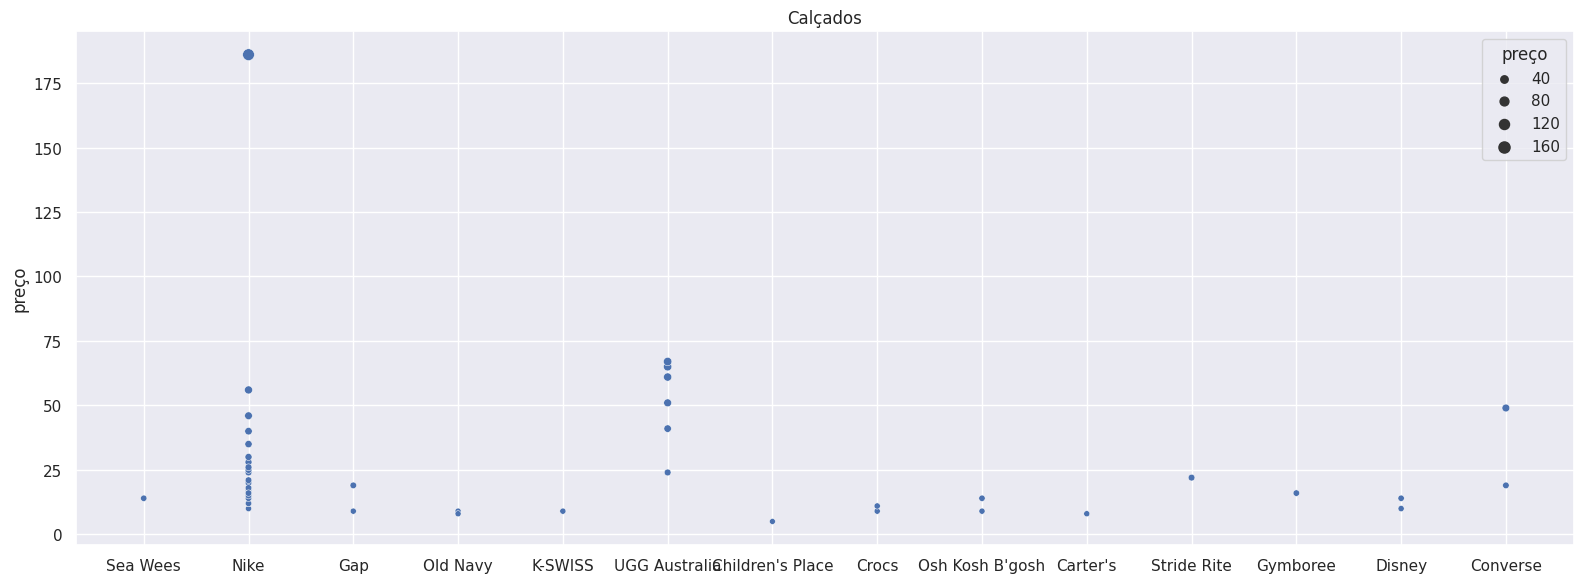

In [27]:
plt.figure(figsize=(16,6), dpi=100)
sns.scatterplot(x='nome_marca', y='preço', size='preço', palette='tab10' , data= analise_do_item.head(100))
plt.title('Calçados')
plt.xlabel('')
plt.tight_layout()
plt.show()

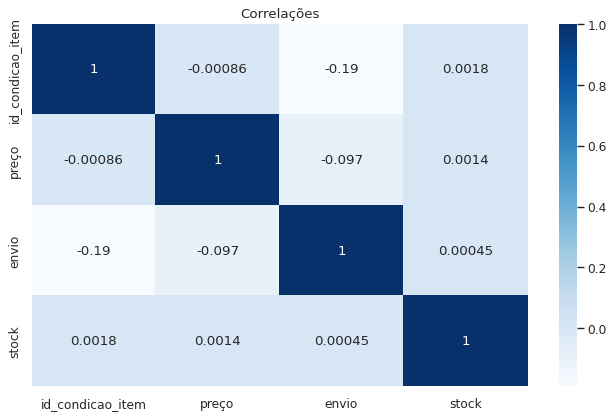

In [28]:
plt.figure(figsize=(10,6), dpi=80)
sns.heatmap(train[['id_condicao_item', 'preço', 'envio', 'stock']].corr(), cmap='Blues', annot=True)
plt.title('Correlações')
plt.show()

# Transformação dos Dados

### Produtos repetidos

In [29]:
print(f'Quantidade de registros: {train.shape[0]}')

Quantidade de registros: 1476208


In [30]:
produtos_unicos = len(train["nome_produto"].unique())
print(f'Quantidade de produtos unicos: {produtos_unicos}')

Quantidade de produtos unicos: 1220180


In [31]:
valores_repetidos = (produtos_unicos - train.shape[0]) / train.shape[0] * 100
print(f"Produtos repetidos representão: {round(valores_repetidos, 4)} % do conjunto de dados")

Produtos repetidos representão: -17.3436 % do conjunto de dados


### Excluir linhas duplicadas: onde a "Marca", "Produto" e "Preço" forem iguais

In [32]:
# dropping ALL duplicate values
dados_unicos = train.drop_duplicates(subset =['nome_produto', 'nome_marca', 'preço', 'id_condicao_item'],
                     keep= 'first', inplace = False)

In [33]:
dados_unicos.shape

(1425251, 11)

### Reduzir a maior categoria

In [34]:
dados_unicos['categoria'].value_counts()

Women                     640667
Beauty                    198179
Kids                      168761
Electronics               117854
Men                        91422
Home                       65582
Vintage & Collectibles     45608
Other                      43434
Handmade                   29140
Sports & Outdoors          24604
Name: categoria, dtype: int64

In [35]:
maior_categoria = dados_unicos[dados_unicos['categoria'] == 'Women']

In [36]:
maior_categoria[['nome_marca', 'nome_produto']].value_counts()

nome_marca    nome_produto                        
Michael Kors  Michael Kors Purse                      116
Coach         Coach purse                             112
Michael Kors  Michael Kors                            107
Coach         Coach Purse                             104
Michael Kors  Michael Kors Wallet                     101
                                                     ... 
Joe's Jeans   BUNDLE FOR NATALIEC2012                   1
              5 listing bundle for Kbhallberg           1
              5 Pairs of Joe's Jeans size W 29          1
              (W 30) Joe's jeans and VS spell mist      1
wallis        Aztec print jumpsuit                      1
Length: 374520, dtype: int64

In [37]:
maior_categoria_new = maior_categoria.drop_duplicates(subset =['nome_marca', 'nome_produto'],
                     keep= 'first', inplace = False)

In [38]:
maior_categoria_new[['nome_marca', 'nome_produto']].value_counts()

nome_marca  nome_produto                           
!iT Jeans   IT! Jeans 27                               1
PINK        PINK Lanyard Blue/Pink                     1
            PINK Landyard                              1
            PINK Lace up hoodie                        1
            PINK Lace up Dorm Pants Super Soft Tee     1
                                                      ..
J. Crew     J. Crew White Chino Shorts size 2          1
            J. Crew Vintage Cotton Tank                1
            J. Crew Vest xxs and Denim shirt bundle    1
            J. Crew Vest                               1
wallis      Aztec print jumpsuit                       1
Length: 374520, dtype: int64

In [39]:
maior_categoria_new.shape

(555959, 11)

In [40]:
# Converter index em array e dropar aqueles que não correpondem a valores unicos. Apagaremos do DataFrame os produtos e marcas repetidos

index_maior_categoria = maior_categoria_new.index 
index_maior_categoria = np.array(index_maior_categoria)

index_dados_unicos = dados_unicos[dados_unicos['categoria'] == 'Women'].index
index_dados_unicos = np.array(index_dados_unicos)

drop_index = np.setdiff1d(index_dados_unicos, index_maior_categoria)
dados_unicos = dados_unicos.drop(drop_index, axis=0) 

In [41]:
dados_unicos['categoria'].value_counts()

Women                     555959
Beauty                    198179
Kids                      168761
Electronics               117854
Men                        91422
Home                       65582
Vintage & Collectibles     45608
Other                      43434
Handmade                   29140
Sports & Outdoors          24604
Name: categoria, dtype: int64

### Outliers

In [42]:
percentil = dados_unicos['preço'].quantile(.98)
outliers = dados_unicos[dados_unicos['preço'] > percentil]

In [43]:
porcentagem_outliers = (outliers.shape[0] / dados_unicos.shape[0]) * 100
print(f"Porcentagem de outliers representão: {round(porcentagem_outliers, 4)} % do conjunto de dados")

Porcentagem de outliers representão: 1.9843 % do conjunto de dados


In [44]:
outliers['categoria'].value_counts()

Women                     10849
Electronics                6918
Men                        3540
Kids                       1528
Vintage & Collectibles     1110
Beauty                      958
Home                        625
Other                       416
Sports & Outdoors           378
Handmade                    278
Name: categoria, dtype: int64

In [45]:
outliers.head(6)

,nome_produto,id_condicao_item,nome_marca,preço,envio,descricao_item,data,stock,categoria,sub_categoria,sub_categoria_item
id,,,,,,,,,,,
22,Galaxy S7 Edge (Unlocked) 32GB,3,Samsung,386.0,0,"Reasonable offers welcomed. But if you ask ""lo...",11-9-2018,6,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones
36,Black bag 30,3,NaN,209.0,0,Pre-owned. Some light scratches on hardware co...,10-8-2018,9,Women,Women's Handbags,Totes & Shoppers
38,XBOX One,3,Xbox,226.0,0,500GB Comes with power cord One controller wit...,26-9-2018,26,Electronics,Video Games & Consoles,Consoles
94,Hatchimals Draggle,1,Spin Master,150.0,1,BNIP VHTF! HOTTEST toy of the season!,4-4-2018,15,Kids,Toys,Electronics for Kids
145,Air Jordan 1 Breds 2016,1,Air Jordan,250.0,1,"Sz 10 Never been worn, comes with receipt Don'...",3-9-2018,33,Men,Shoes,Athletic
150,Kate spade mylie black hobo crossbody,1,Kate Spade,145.0,0,"Your ever-faithful companion, the Kate Spade N...",21-3-2018,11,Women,Women's Handbags,Hobo


In [46]:
dados_unicos.shape

(1340543, 11)

In [47]:
#drop outliers

index_outliers = outliers.index 
dados_unicos = dados_unicos.drop(index_outliers, axis=0) 

In [48]:
dados_unicos.shape

(1313943, 11)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


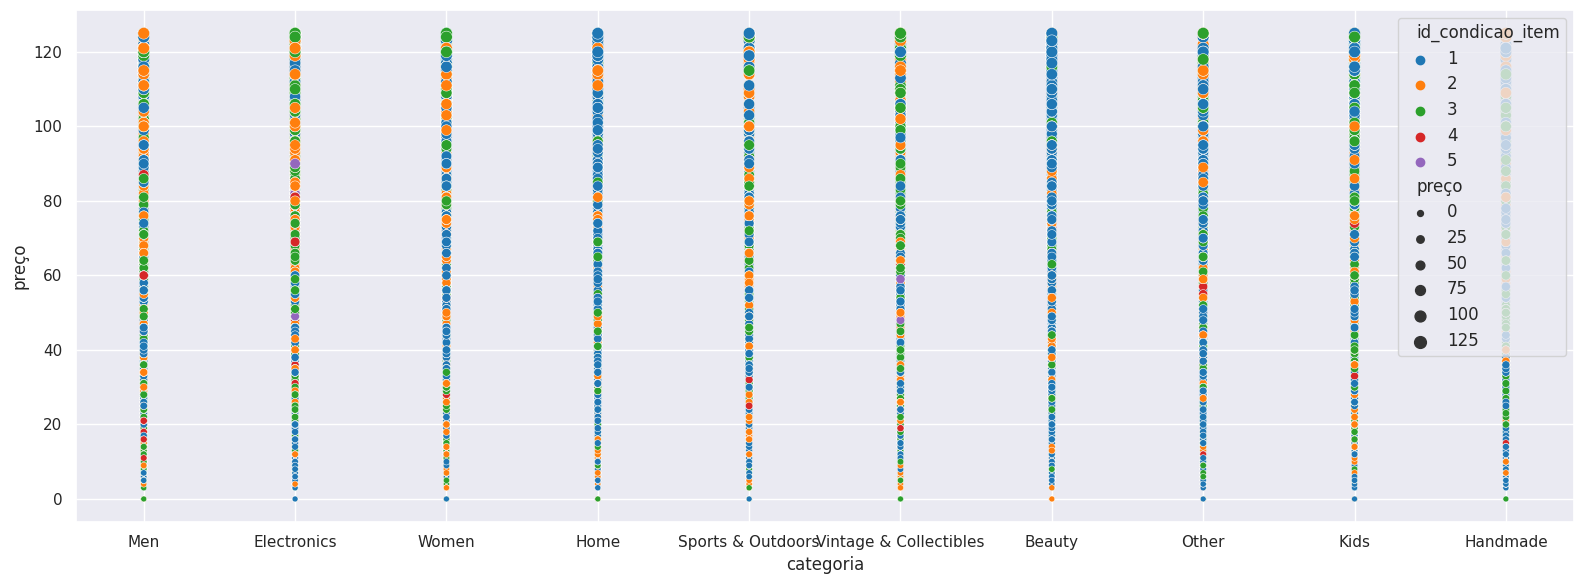

In [49]:
plt.figure(figsize=(16,6), dpi=100)
sns.scatterplot(x='categoria', y='preço', hue='id_condicao_item', size='preço', palette='tab10' , data= dados_unicos)
plt.tight_layout()
plt.show()

### Balanceamento

### Engenharia de Recursos

In [50]:
train.head()

,nome_produto,id_condicao_item,nome_marca,preço,envio,descricao_item,data,stock,categoria,sub_categoria,sub_categoria_item
id,,,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,NaN,10.0,1,No description yet,23-1-2018,27,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,19-9-2018,15,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,15-3-2018,14,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,6-9-2018,1,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,NaN,44.0,0,Complete with certificate of authenticity,5-1-2018,13,Women,Jewelry,Necklaces


### Normalização dos Dados

In [51]:
train.head()

,nome_produto,id_condicao_item,nome_marca,preço,envio,descricao_item,data,stock,categoria,sub_categoria,sub_categoria_item
id,,,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,NaN,10.0,1,No description yet,23-1-2018,27,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,19-9-2018,15,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,15-3-2018,14,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,6-9-2018,1,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,NaN,44.0,0,Complete with certificate of authenticity,5-1-2018,13,Women,Jewelry,Necklaces


### Preenchendo Dados Nulos 